In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.autograd import grad
import seaborn as sns
import pandas as pd
import sys

In [2]:
def fm(x,y):
    return torch.sum(7*x) + torch.sum(y**2)

In [3]:
def gm(x,y):
    return torch.sum( 3*(y - x)**2 )

In [7]:
ilr = 0.1
x = Variable(torch.Tensor([7.0, 4.0]), requires_grad=True)
y = Variable(torch.Tensor([20, 30]), requires_grad=True)
for i in range(100):
    grad_y = torch.autograd.grad(gm(x,y), y, create_graph=True)[0]
    new_y = y - ilr*grad_y
    y = Variable(new_y, requires_grad=True)

## Forward mode

In [6]:
def compute_full_second_derivative(vec_func, var):
    tmp = torch.zeros(vec_func.shape[0], vec_func.shape[0])
    for i, loss in enumerate(vec_func):
        tmp[:,i] = torch.autograd.grad(loss, var, retain_graph=True)[0]
    return tmp

In [7]:
def do_forward_multidim(dim, T, mem=False):
    lr = 0.1 # Outer learning rate
    ilr = 0.1 # Inner learning rate
    x = Variable(torch.randn(dim), requires_grad=True)
    y = Variable(torch.randn(dim), requires_grad=True)
    ##
    Z = torch.zeros(x.shape[0], y.shape[0]) 

    for i in range(T):
        # We nee to compute the total derivative of f wrt x
        #y = 0.0

        for j in range(T):
            grad_y = torch.autograd.grad(gm(x,y), y, create_graph=True)[0]
            new_y = y - ilr*grad_y
            ##
            A_tensor = compute_full_second_derivative(new_y, x)
            B_tensor = compute_full_second_derivative(new_y, y)
            ##
            Z = Z @ A_tensor + B_tensor
            y = Variable(new_y, requires_grad=True)

        grad_x = torch.autograd.grad(fm(x,y), x, retain_graph=True)[0] 
        grad_y = torch.autograd.grad(fm(x,y), y)[0]
        ##
        x = x - lr*(grad_x + Z @ grad_y)
        
    if mem:
        memory_usage = ( sys.getsizeof(Z.storage()) + sys.getsizeof(x.storage()) +
            sys.getsizeof(y.storage()) + sys.getsizeof(grad_y.storage()) +
            sys.getsizeof(grad_x.storage()) )
        
        return x, memory_usage
         
    
    else:
       
        return x
        

In [7]:
do_forward_multidim(1, 40)

tensor([-3.4995], grad_fn=<SubBackward0>)

In [8]:
result = %timeit -o do_forward_multidim(1, 40)

682 ms ± 43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Backward mode

In [4]:
def do_backward_multidim(dim, T, mem=False):
    lr = 0.1 # Outer learning rate
    ilr = 0.1 # Inner learning rate
    x = Variable(torch.randn(dim), requires_grad=True)
    y = Variable(torch.randn(dim), requires_grad=True)
    ##
    yt = torch.zeros(T, y.shape[0])

    for i in range(T):
       
        # We nee to compute the total derivative of f wrt x
        ##    
        for j in range(T):
            grad_y = torch.autograd.grad(gm(x,y), y, create_graph=True)[0]
            new_y = y - ilr*grad_y
            y = Variable(new_y, requires_grad=True)
            yt[j] = y
        ###
        alpha = -torch.autograd.grad(fm(x,y), y, retain_graph=True)[0]
        gr = torch.zeros_like(alpha)
        ###
        for j in range(T-1,-1,-1):
            y_tmp = Variable(yt[j], requires_grad=True)
            grad_y, = torch.autograd.grad( gm(x,y_tmp), y_tmp, create_graph=True )
            loss = -ilr*grad_y@alpha
            #loss = y_tmp - ilr*grad_y
            #loss = loss@alpha
            aux1 = torch.autograd.grad(loss, x, retain_graph=True)[0]
            aux2 = torch.autograd.grad(loss, y_tmp)[0]
            gr -= aux1
            alpha += aux2

        grad_x = torch.autograd.grad(fm(x,y), x)[0] 
        ##
        x = x - lr*(grad_x + gr)
        
    if mem:
        memory_usage = ( sys.getsizeof(yt.storage()) + sys.getsizeof(x.storage()) +
            sys.getsizeof(y.storage()) + sys.getsizeof(grad_y.storage()) +
            sys.getsizeof(grad_x.storage()) + sys.getsizeof(gr.storage()) +
            sys.getsizeof(alpha.storage()) + sys.getsizeof(y_tmp.storage()) +
            sys.getsizeof(loss.storage()) )
        
        return x, memory_usage
    
    else:
       
        return x,y

In [6]:
do_backward_multidim(1, 40)

(tensor([-3.4996], grad_fn=<SubBackward0>),
 tensor([-3.4994], requires_grad=True))

## Time comparison

In [ ]:
dimensions = np.array([1,2,5,10,50,100,500])
time_fw = np.zeros(len(dimensions))
sd_fw = np.zeros(len(dimensions))
##
for i, d in enumerate(dimensions):
    result = %timeit -o do_forward_multidim(int(d), 40)
    ts = result.average
    sd = result.stdev
    time_fw[i] = ts
    sd_fw[i] = sd

In [13]:
dimensions = np.array([1,2,5,10,50,100,500])
time_bw = np.zeros(len(dimensions))
sd_bw = np.zeros(len(dimensions))
##
for i, d in enumerate(dimensions):
    result = %timeit -o do_backward_multidim(int(d), 40)
    ts = result.average
    time_bw[i] = ts
    sd = result.stdev
    sd_bw[i] = sd

813 ms ± 37.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
743 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
738 ms ± 72.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
728 ms ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.38 s ± 639 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.65 s ± 566 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.19 s ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [154]:
data = pd.DataFrame({"Time_Forward":time_fw, "Std_Forward":sd_fw,
                     "Time_Backward": time_bw, "Std_Backward": sd_bw,
                    "N": dimensions})

data.head()

Time_Forward  Std_Forward  Time_Backward  Std_Backward   N
0      0.938118     0.070265       0.737736      0.065581   1
1      1.388932     0.195490       0.735050      0.137592   2
2      2.589588     0.245338       0.768834      0.131820   5
3      5.236286     0.362323       0.870149      0.090468  10
4     23.466005     0.728319       0.829966      0.088423  50

In [183]:
df_long = data.melt(id_vars=['N'])
df_long[['Qty', 'Type']] = df_long['variable'].str.split("_", n=1, expand=True)
df_wide = df_long.pivot_table(index=['N', 'Type'],
                              columns='Qty', values='value').reset_index()
df_wide

Qty    N      Type        Std        Time
0      1  Backward   0.065581    0.737736
1      1   Forward   0.070265    0.938118
2      2  Backward   0.137592    0.735050
3      2   Forward   0.195490    1.388932
4      5  Backward   0.131820    0.768834
5      5   Forward   0.245338    2.589588
6     10  Backward   0.090468    0.870149
7     10   Forward   0.362323    5.236286
8     50  Backward   0.088423    0.829966
9     50   Forward   0.728319   23.466005
10   100  Backward   0.077967    0.768835
11   100   Forward   1.442932   68.830807
12   500  Backward   0.143089    0.826470
13   500   Forward  82.768288  254.958453

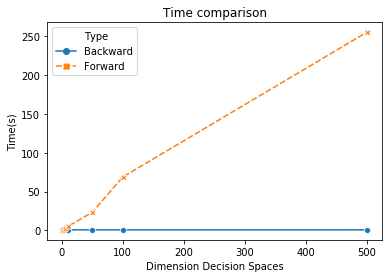

In [193]:
ax = sns.lineplot(x="N", y="Time",
                hue="Type", style="Type",
                markers=True, dashes=True, data=df_wide)

ax.set(xlabel='Dimension Decision Spaces', ylabel='Time(s)', title = 'Time comparison')
plt.savefig('time_comp.eps', format='eps', dpi = 1000)

## Memory comparison

In [9]:
T = np.array([1,2,5,10,50,100])
mem_bw = np.zeros(len(T))
mem_fw = np.zeros(len(T))

In [10]:
for i, t in enumerate(T):
    _, mem = do_backward_multidim(10,int(t), True)
    mem_bw[i] = mem
    print('Backward')
    print(t, mem_bw[i])
    _, mem = do_forward_multidim(10,int(t), True)
    mem_fw[i] = mem
    print('Forward')
    print(t, mem_fw[i])

0
Backward
1 900.0
Forward
1 880.0
0
Backward
2 980.0
Forward
2 880.0
0
Backward
5 1220.0
Forward
5 880.0
0
Backward
10 1620.0
Forward
10 880.0
0
10
20
30
40
Backward
50 4820.0
Forward
50 880.0
0
10
20
30
40
50
60
70
80
90
Backward
100 8820.0
Forward
100 880.0


In [15]:
data = pd.DataFrame({"Mem_Forward":mem_fw,"Mem_Backward": mem_bw,
                    "N": T})

df_long = data.melt(id_vars=['N'])
df_long[['Qty', 'Type']] = df_long['variable'].str.split("_", n=1, expand=True)
df_wide = df_long.pivot_table(index=['N', 'Type'],
                              columns='Qty', values='value').reset_index()
ax = sns.lineplot(x="N", y="Mem",
                hue="Type", style="Type",
                markers=True, dashes=True, data=df_wide)

ax.set(xlabel='T', ylabel='Memory(bytes)', title = 'Memory comparison')
#plt.show()
plt.savefig('mem_comp.eps', format='eps', dpi = 1000)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
